In [1]:
import matplotlib.widgets
from plantcv import plantcv as pcv
#import videometer.hips as hips
import numpy as np
import argparse
import glob
import plantcv.plantcv as pcv
from skimage import img_as_ubyte

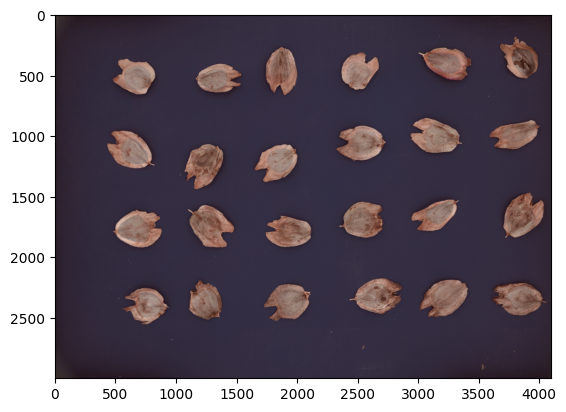

In [6]:
# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "plot"
pcv.params.text_size = 5
pcv.params.text_thickness = 5

#read in image
img = pcv.readimage(filename="F:/Landrigan/envi/Plate118.raw", mode="envi")

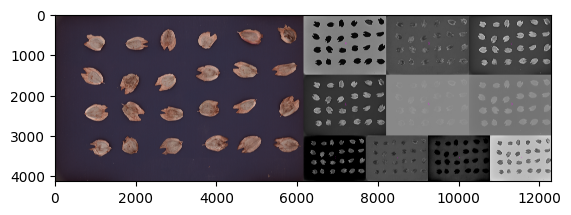

In [7]:
colorspace_img = pcv.visualize.colorspaces(rgb_img=img.pseudo_rgb)

In [ ]:
#channels = [img_as_ubyte(img.array_data[:, :, i] / 255) for i in range(img.array_data.shape[2])]
#tiles = pcv.visualize.tile(images=channels, ncol=4)

In [ ]:
#pcv.print_image(tiles, "videometer-tiles.png")

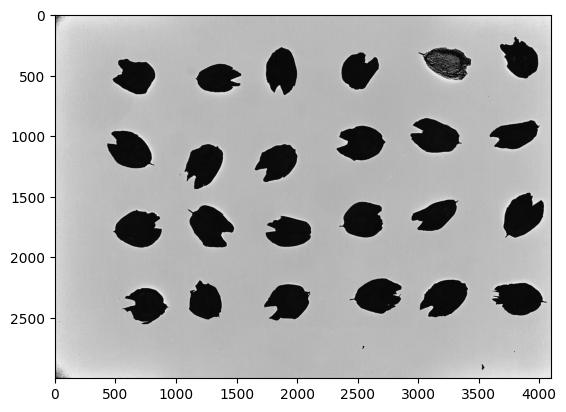

In [8]:
c_img = pcv.rgb2gray_hsv(rgb_img=img.pseudo_rgb, channel='h')

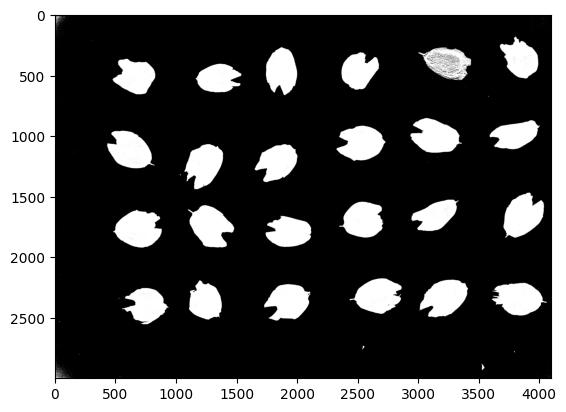

In [9]:
#c_thresh = pcv.threshold.otsu(gray_img=c_img, object_type='dark')
c_thresh = pcv.threshold.mean(gray_img=c_img, ksize=22000, offset=40, object_type='dark')

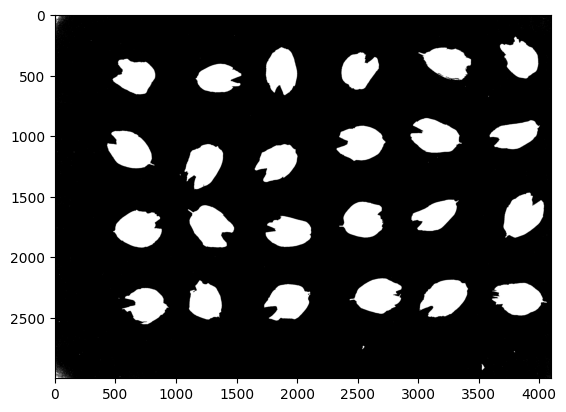

In [10]:
c_fill = pcv.fill_holes(bin_img=c_thresh)

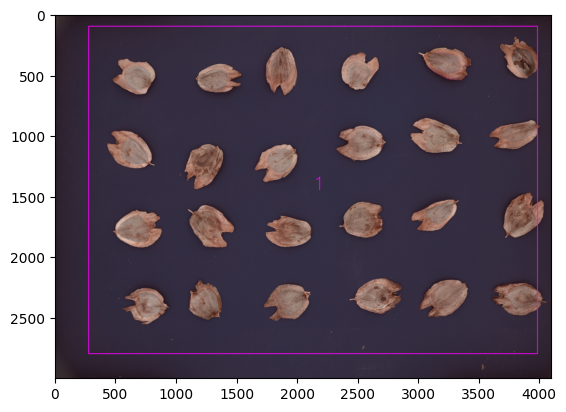

In [11]:
roi = pcv.roi.rectangle(img=img.pseudo_rgb, x=277, y=100, h=2700, w=3700)

In [ ]:
#roi = pcv.roi.rectangle(img=img.pseudo_rgb, x=277, y=250, h=2200, w=3400)

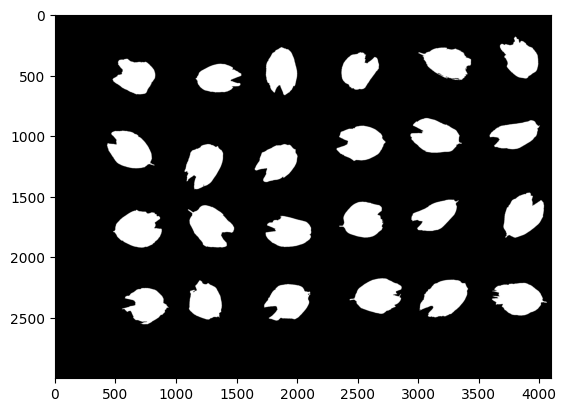

In [12]:
a_fill_image = pcv.fill(bin_img=c_fill, size=18000)

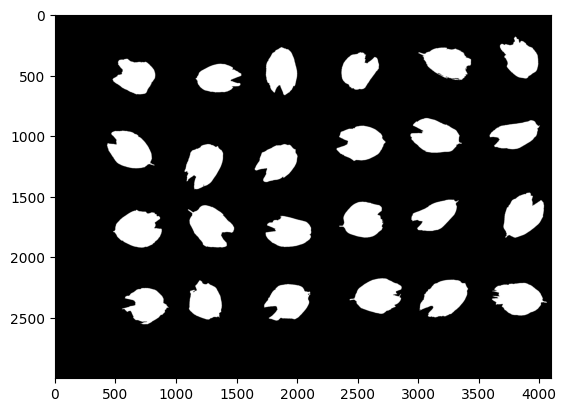

In [13]:
flt_mask = pcv.roi.quick_filter(mask=a_fill_image, roi=roi)

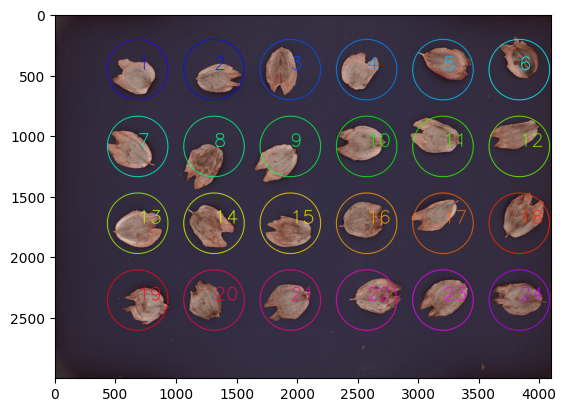

In [14]:
rois = pcv.roi.auto_grid(mask=flt_mask, nrows=4, ncols=6, radius=250, img=img.pseudo_rgb)

In [ ]:
labeled_mask, num = pcv.create_labels(mask=flt_mask, rois=rois)
print(num)

In [ ]:
shape_img = pcv.analyze.size(img=img.pseudo_rgb, labeled_mask=labeled_mask, n_labels=num, label="seed")

In [ ]:
analysis_img = pcv.analyze.spectral_reflectance(hsi=img, labeled_mask=labeled_mask, n_labels=num, label='seed')

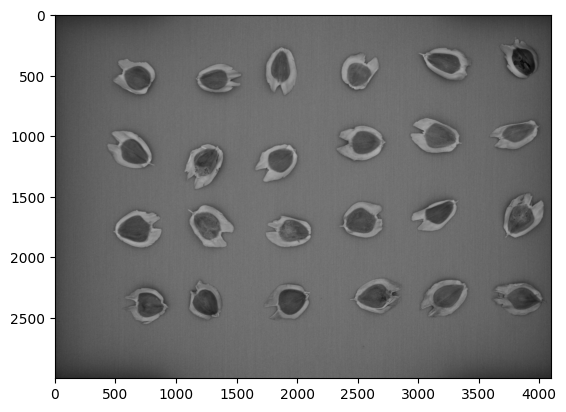

In [238]:
r940 = img_as_ubyte(img.array_data[: , :, -2] / 255)
pcv.plot_image(r940)

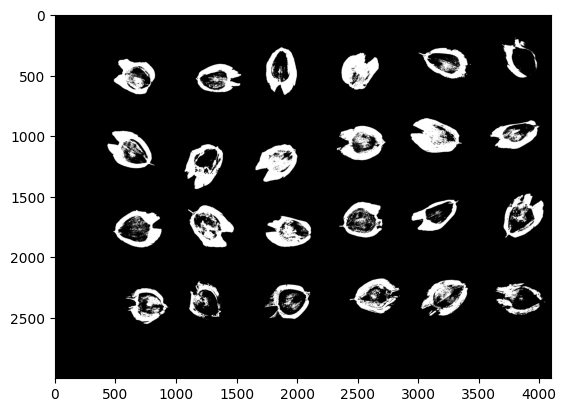

In [234]:
masked_r940 = pcv.apply_mask(img=r940, mask=flt_mask, mask_color="black")

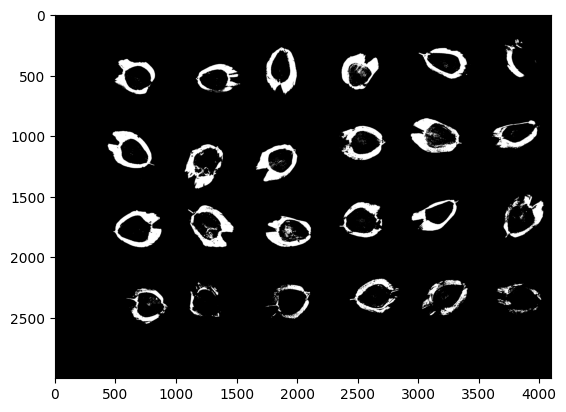

In [236]:
wing_mask = pcv.threshold.binary(gray_img=r940, threshold=30, object_type="light")

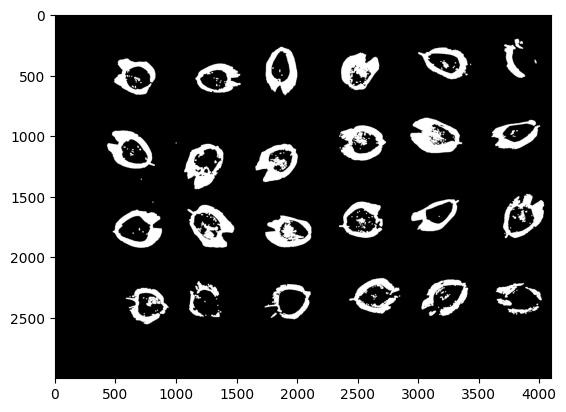

In [237]:
wing_mask_dil = pcv.dilate(gray_img=wing_mask, ksize=5, i=2)
#wing_err = pcv.erode(gray_img=wing_mask, ksize=4, i=1)

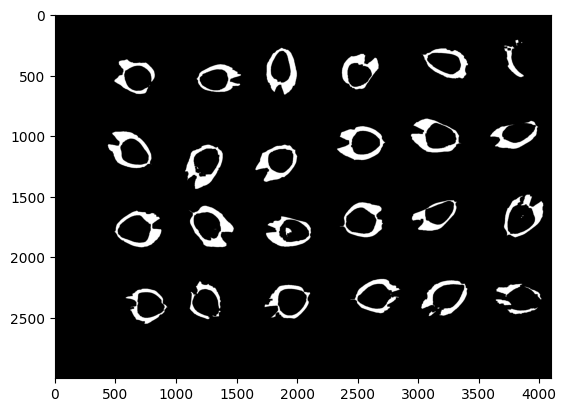

In [125]:
wing_err = pcv.erode(gray_img=wing_mask_dil, ksize=8, i=2)
#wing_mask_dil = pcv.dilate(gray_img=wing_err, ksize=5, i=2)

In [ ]:
wing_mask_clean = pcv.fill(bin_img=wing_mask_dil, size=2500)

In [ ]:
wing_labeled_mask, num = pcv.create_labels(mask=wing_mask, rois=rois)
print(num)

In [ ]:
wing_shape_img = pcv.analyze.size(img=img.pseudo_rgb, labeled_mask=wing_labeled_mask, n_labels=num, label="wing")

In [ ]:
wing_analysis_img = pcv.analyze.spectral_reflectance(hsi=img, labeled_mask=wing_labeled_mask, n_labels=num, label='wing')

In [ ]:
kernel_mask = flt_mask - wing_mask
pcv.plot_image(kernel_mask)

In [ ]:
kernel_err = pcv.erode(gray_img=kernel_mask, ksize=4, i=5)

In [ ]:
kernel_mask_clean = pcv.fill(bin_img=kernel_err, size=2900)

In [ ]:
kernel_mask_dil = pcv.dilate(gray_img=kernel_mask_clean, ksize=4, i=4)

In [ ]:
kernel_labeled_mask, num = pcv.create_labels(mask=kernel_mask_dil, rois=rois)
print(num)

In [ ]:
kernel_shape_img = pcv.analyze.size(img=img.pseudo_rgb, labeled_mask=kernel_labeled_mask, n_labels=num, label="kernel")

In [ ]:
kernel_analysis_img = pcv.analyze.spectral_reflectance(hsi=img, labeled_mask=kernel_labeled_mask, n_labels=num, label='kernel')

In [ ]:
pcv.plot_image(img.array_data[:, :, -1])

In [ ]:
pcv.plot_image(img.array_data[:, :, -2])

In [ ]:
pcv.plot_image(img.array_data[:, :, -3])

In [ ]:
pcv.outputs.save_results(filename='F:/Landrigan/Fix_Thresholding/Results/resultstest.csv', outformat="csv")

In [ ]:
help(pcv.analyze.color)

In [ ]:
def main():
	indir = "F:/Landrigan/Round_3"
	outdir = "F:/Landrigan/Round_3"
	plot = "TRUE"
    
	files = glob.glob(f"{indir}/*.raw")
	for f in files:
		print(f)
		#read image, create mask
		img = pcv.readimage(filename=f, mode="envi")
		c_img = pcv.rgb2gray_hsv(rgb_img=img.pseudo_rgb, channel='h')
		c_thresh = pcv.threshold.binary(gray_img=c_img, threshold=25, object_type='dark')
		c_fill = pcv.fill_holes(bin_img=c_thresh)
		a_fill_image = pcv.fill(bin_img=c_fill, size=10000)
		labeled_mask, num = pcv.create_labels(mask=a_fill_image, )

		if plot == "TRUE":
			outfile = f.removesuffix('.raw').removeprefix(indir)
			x = pcv.visualize.pseudocolor(c_fill, mask=labeled_mask, background='black')
			x.savefig(f'{outdir}/{outfile}.png')
        
		#extract shape and spectral data per seed
		shape_img = pcv.analyze.size(img=img.pseudo_rgb, labeled_mask=labeled_mask, n_labels=num, label="seed")
		hsv_img = pcv.analyze.color(rgb_img=img.pseudo_rgb, labeled_mask=labeled_mask, n_labels=num, label="seed")
		analysis_img = pcv.analyze.spectral_reflectance(hsi=img, labeled_mask=labeled_mask, n_labels=num, label='seed')

		#save outputs
		print(outdir)
		outfile = f.removesuffix('.raw').removeprefix(indir)
		pcv.outputs.save_results(filename=f"{outdir}/{outfile}.csv", outformat="csv")

	return 1

if __name__ == '__main__':
	main()

In [ ]:
modified_spectral = pcv.Spectral_data(array_data=analysis_img,
                           max_wavelength=list(img.wavelength_dict.keys())[-1],
                           min_wavelength=list(img.wavelength_dict.keys())[0],
                           max_value=float(np.amax(analysis_img)),
                           min_value=float(np.amin(analysis_img)),
                           d_type=modified_array_data.dtype,
                           wavelength_dict=img.wavelength_dict,
                           samples=modified_array_data.shape[1],
                           lines=modified_array_data.shape[0], interleave='bil',
                           wavelength_units=img.wavelength_units,
                           array_type="datacube",
                           pseudo_rgb=None,
                           filename=img.filename,
                           default_bands=None)

In [ ]:
args = options("F:/Landrigan/Fix_Thresholding", "F:/Landrigan/Fix_Thresholding/Results", True)
args